# Suncal API User Manual: Optimizing Calibration Intervals

Calibration Interval calculations in suncal are based on NCSLI Recommended Pracitce 1 (RP-1). Methods A3 and S2 are implemented in the `TestInterval` and `BinomialInterval` classes, respectively. The other methods described in RP-1 were not implemented because they are "not recommended but remain documented in this RP to discourage its “reinvention” and maintain awareness of the drawbacks of similar methods."

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Method A3 - Test Interval Method

Use Method A3 if all historical calibrations were done at nearly the same interval. It calculates a new interval based on observed reliability of all calibrations done under the same interval.


In [2]:
from suncal.intervals import TestInterval, TestIntervalAssets

The `TestInterval` model requires the number of in-tolerance calibrations, total number of calibrations, the assigned interval of those calibrations, and the target reliability.

Below, y is a list of pass/fail (1/0) values on DUTs of the same category calibrated with the same interval of 365 days.
(Data from 2019 NCSLI Symposium Tutorial on Intervals).

The calculation is run and result with report attribute is returned just like other suncal model types. For this set of data, the interval recommended by the A3 calculation is 231 days.

In [3]:
y = np.array([1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,])  # Pass/fail values
model = TestInterval(intol=np.count_nonzero(y), n=len(y), I0=365, Rt=.95)  # Existing interval I0=365 days.
result = model.calculate()
result.interval

230.84604619402594

In [4]:
result.report.summary()

|Parameter                              | Value            |
|--------------------------------------|-----------------|
|Suggested Interval                     | 231         |
|Calculated Interval                    | 231         |
|Current Interval Rejection Confidence  | 99.49%           |
|True reliability range                 | 65.16% - 82.86%  |
|Observed Reliability                   | 75.00% (15 / 20) |
|Number of calibrations used            | 20               |

If the data takes the form of calibration dates and pass/fail status for each DUT, use the `TestIntervalAssets` class to set up the calculation, and the `updateasset` method to add calibration outcomes for a single asset.
Using this model, multiple assets of the same category may be pooled (using additional calls to `updateasset`) to provide more statistics for a higher confidence in the resulting interval.
Suncal will inspect the dates and include only those calibrations whose interval was close to the assigned interval I0. Some may be discarded if the actual interval was too long or short for not having reliability representative of the assigned interval length.

The last line in output table lists how many calibrations were discarded.

In [5]:
y = np.array([1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,])  # Pass/fail values
startdates = np.arange(0, 365*(len(y)), step=365)
caldates = np.arange(365, 365*(len(y)+1), step=365)  # Just make all cal intervals exactly 365
intv = TestIntervalAssets(I0=365, Rt=.95)
intv.updateasset('asset123', startdates=startdates, enddates=caldates, passfail=y)
result = intv.calculate()
result

|Parameter                               | Value            |
|---------------------------------------|-----------------|
|Suggested Interval                      | 231         |
|Calculated Interval                     | 231         |
|Current Interval Rejection Confidence   | 99.49%           |
|True reliability range                  | 65.16% - 82.86%  |
|Observed Reliability                    | 75.00% (15 / 20) |
|Number of calibrations used             | 20               |
|Rejected calibrations (wrong interval)  | 0                |

## Method S2 - Binomial Method

The S2 method uses the observed measurement reliability as a function of time between calibrations, fit to several different reliability models, to determine the best interval. Use this method if historical calibrations have been made at many different intervals.

Data may be entered as time-since-calibraiton vs. reliability using `BinomialInterval()` or as calibration time vs. pass/fail for individual assets using `BinomialIntervalAssets()`.

Running `.calculate()` will compute all the reliability models, assign a figure of merit to each, and return the results object, containing the interval resulting from the best model.

Working the example from Table D-1 in RP-1, which lists weeks between calibrations, number of calibrations in each interval, and observed reliability in that interval:

In [6]:
from suncal.intervals import BinomialInterval, BinomialIntervalAssets

In [7]:
# Reliability data from Table D-1 in RP1
ti = [4,7,10,13,21,28,40,48]           # Weeks between calibrations
ni = np.array([4,6,14,13,22,49,18,6])  # Number of calibrations in each interval of ti
Ri = [1.0, .83333, .6429, .6154, .5455, .4082, .5000, .3333]    # Observed measurement reliability

These values are given to the `BinomialInterval` class. Calculating returns a result object where the different reliability models are evaluated, and the best one chosen to select the new recommended interval, accessible in the `result.interval` attribute.

In [8]:
model = BinomialInterval(Rtarget=.75, ti=ti, Ri=Ri, ni=ni)
result = model.calculate()
result.interval

9.0

To see the results from all the fit models that were evaluated:

In [9]:
result.report.allmodels()

|Reliability Model   | Interval   | Rejection Confidence   | F-Test    | Figure of Merit  |
|-------------------|----------|----------------------|---------|-----------------|
|Random Walk         | 9          | 7.04%                  | True      | 196.74           |
|Restricted Walk     | 8          | 7.54%                  | True      | 178.53           |
|Mortality Drift     | 8          | 10.55%                 | True      | 127.55           |
|Log Normal          | 9          | 15.33%                 | True      | 90.39            |
|Mixed Exponential   | 8          | 15.37%                 | True      | 87.52            |
|Weibull             | 9          | 22.50%                 | True      | 61.58            |
|Warranty            | 8          | 59.55%                 | True      | 22.59            |
|Drift               | 8          | 70.51%                 | True      | 19.08            |
|Exponential         | 11         | 26.58%                 | True      | 6.85             |
|Modified Gamma      | 19         | 99.30%                 | False     | 2.10             |

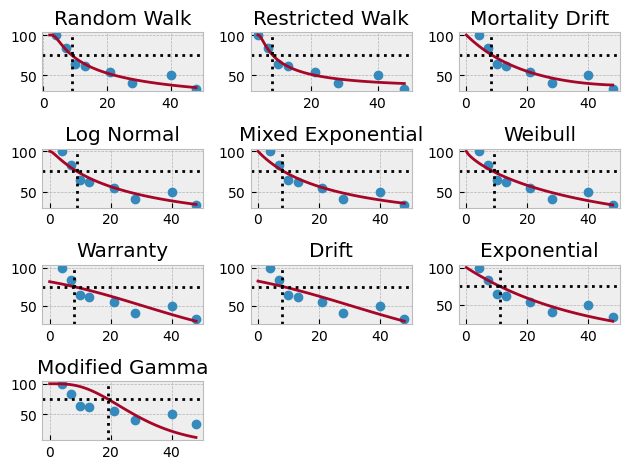

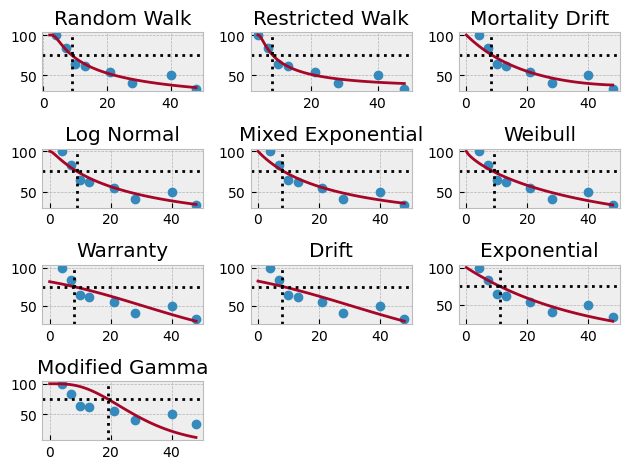

In [10]:
result.report.plot.allmodels()

### Data as individual calibrations

If the data is in terms of calibration date and pass/fail, rather than summarized reliability vs interval values, use the `BinomailIntervalAssets` class. The `updateasset` method can be called with calibration dates and pass/fail values on an individual asset. Data from multiple assets can be combined using different asset names in `updateasset`. The data will be converted into time-betwee-calibrations vs observed measurement reliability by binning into ten intervals (by default).

In [11]:
# Make up some data based on RP-1 table D-1. Results won't be the same because RP1 used hand-selected bin edges.
enddate = [0]
passfail = [1]

def addit(passes, total, weeks):
    for i in range(total):
        enddate.append(enddate[-1] + np.random.uniform(*weeks))
    passfail.extend([1]*passes + [0]*(total-passes))
    
addit(4, 4, (2, 4))
addit(5, 6, (5, 7))
addit(9, 14, (8, 10))
addit(8, 13, (11, 13))
addit(12, 22, (19, 21))
addit(20, 49, (26, 28))
addit(9, 18, (37, 40))
addit(2, 6, (48, 51))

In [12]:
# Calculate the interval
model = BinomialIntervalAssets(Rt=.8, bins=10)
model.updateasset('asset123', enddate, passfail)
result = model.calculate()
result.report.allmodels()

|Reliability Model   | Interval   | Rejection Confidence   | F-Test    | Figure of Merit  |
|-------------------|----------|----------------------|---------|-----------------|
|Restricted Walk     | 9          | 5.57%                  | True      | 186.54           |
|Random Walk         | 9          | 5.97%                  | True      | 174.15           |
|Mortality Drift     | 7          | 8.64%                  | True      | 112.90           |
|Mixed Exponential   | 6          | 11.31%                 | True      | 83.05            |
|Weibull             | 6          | 15.21%                 | True      | 61.73            |
|Exponential         | 9          | 20.39%                 | True      | 50.97            |
|Warranty            | 0          | 100.00%                | False     | 0.00             |
|Drift               | 0          | 100.00%                | False     | 0.00             |
|Modified Gamma      | 17         | 99.34%                 | False     | 2.04             |
|Log Normal          | 12         | 100.00%                | False     | 1.86             |

## Variables Method

Based on Castrup "Calibration Intervals from Variables Data", 2005 NCSLI Workshop & Symposium, Washington D.C, and "Establishment and Adjustment of Calibration Intervals", NASA Measurement Quality Assurance Handbook - Annex 5 (2010). NASA-HDBK-8739.19-5.

The `VariablesInterval` class implements both methods described in Castrup's paper: the Reliability Target method and the Uncertainty Target method. Both methods operate on data in the format of deviation-from-prior-calibration versus time-since-last-calibration.

Depending on the format of the input data, there two options for setting up the calculation:

1. Use `VariablesIntervalAssets` if the data is in as-found and as-left measurement format
2. Use `VariablesInterval` if the data is already in time-since-last, deviation-from-prior format

In [13]:
from dateutil import parser

from suncal.intervals import VariablesInterval, VariablesIntervalAssets

### Data in As-found and As-left format

If the data is given in as-found and as-left measurement values, use the `VariablesIntervalAssets` method to initialize the calculation.

If as-found equals as-left (i.e. no adjustments were made during any calibration), setting `use_all_deltas=True` will extract non-consecutive intervals from the as-found data, for example by including the interval between the first and third calibrations.

Here, we make up some random data, equally spaced in time. With all the actual intervals the same length, it is impossible to fit a curve to $\Delta y$ vs $\Delta t$. However, because no adjustments were made (yfound == yleft), `use_alldeltas` was set to extract other interval lengths and provide values that can be fit.

In [14]:
m = -.005  # Slope
s = .05    # Scatter
day = np.linspace(20, 40, num=10)   # Actual date of calibration
np.random.seed(342342)
yfound = np.random.normal(day*m, s)

v = VariablesIntervalAssets(u0=0.05, use_alldeltas=True, utarget=0.1, rlimits=(-0.5, 0.5), rconf=0.9)
v.updateasset('asset123', enddates=day, asfound=yfound)
results = v.calculate()  # Runs both methods
results.reliabilitytarget.interval, results.uncertaintytarget.interval

(45.686060302697605, 51.9309811139139)

Information about the curve fit itself is available:

In [15]:
results.report.fit.summary()

### Fit line


|Parameter   | Value     | Std. Uncertainty  |
|-----------|---------|------------------|
|a           | -0.0074  | 0.0011          |


Standard Error:   0.067

In [16]:
print(results.report.fit.b)     # Fit parameters as an array (length 1 for a line fit)
print(results.report.fit.cov)   # Covariance of fit parameters (1x1 for m=1 line fit)

[-0.00739283]
[[1.10768126e-06]]


## Data as $\Delta$t, $\Delta$y values

If the data is already formatted in terms of time-since-last-calibration and deviation-from-prior calibration, use `VariablesInterval(dt, dy)` to initialize the calculator.

This example approximates uses the data in Table 7-2 of NASA Handbook. Compare with results in Table 7-4 and 7-7.

In [17]:
dt = np.array([70, 86, 104, 135, 167, 173])
deltas = np.array([.1, .11, .251, .299, .403, .615])
model = VariablesInterval(dt, deltas, u0=.28, m=2, y0=10.03, utarget=.5, rlimits=(9, 11), rconf=.9)
results = model.calculate()
results.reliabilitytarget.interval, results.uncertaintytarget.interval

(140.09098193839836, 327.153339838551)

One-sided tolerances can be given by setting the other limit to None. Compare with results in NASA Table 7-5 and 7-6.

In [18]:
model = VariablesInterval(dt, deltas, u0=.28, m=2, y0=10.03, utarget=.5, rlimits=(None, 11), rconf=.9)
model.calc_reliability_target()

### Interval: 171.75



![IMG0][]





[IMG0]: 

In [19]:
# Not sure this is a good example by NASA.. initial uncertainty is below the target! But that's
# their example. NASA's table 7-2 shows the interval as 153, the point where the k=1.53 line
# crosses the lower limit.
model = VariablesInterval(dt, deltas, u0=.28, m=2, y0=9.03, rlimits=(9, None), rconf=0.9)
model.calc_reliability_target()

### Interval: 0.00



![IMG0][]





[IMG0]: 

Castrup's Paper has data in Table 1, but it does not match the later figures and screenshots.

In [20]:
# Test with data from Castrup Table 1
dates = [parser.parse('29-Mar-03'),
         parser.parse('11-Jul-03'),
         parser.parse('31-Dec-03'),
         parser.parse('15-May-04'),
         parser.parse('29-Oct-04'),
         parser.parse('23-Jan-05'),
         parser.parse('03-Apr-05')]

asfound = np.array([5.173, 5.123, 4.633, 4.915, 5.086, 4.913, 5.108])
asleft = np.array([5.073, 5.048, 4.993, 5.126, 5.024, 5.208, 5.451])
uncert = np.array([.2700, .2825, .2771, .2700, .2825, .2771, .2759])
datesord = np.array([d.toordinal() for d in dates])  # Ordinal day

model = VariablesIntervalAssets(u0=.25, y0=0, utarget=.4, rlimits=(-.810, .595), rconf=.80)
model.updateasset('asset1', enddates=datesord, asfound=asfound, asleft=asleft)
model.calculate()

|Method              | Interval   | Predicted value at end of interval  |
|-------------------|----------|------------------------------------|
|Uncertainty Target  | 608.15     | -0.61 ± 0.40 (k = 1.00)      |
|Reliability Target  | 327.46     | -0.33 ± 0.40 (k = 1.48)      |


![IMG0][]



![IMG1][]




---

### Deviation Values


|Time since calibration   | Deviation from prior  |
|------------------------|----------------------|
|70                 | -0.10              |
|86                 | -0.11              |
|104                 | 0.050              |
|136                 | -0.078              |
|167                 | -0.040              |
|173                | -0.42             |


![IMG2][]



### Fit line


|Parameter   | Value     | Std. Uncertainty  |
|-----------|---------|------------------|
|a           | -0.00101  | 0.00046          |


Standard Error:   0.14

[IMG0]: 
[IMG1]: 
[IMG2]: 